In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import local_config
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pygraphviz as pg
import re

In [3]:
def jgraph_from_links_filtered(df):
    """
    Function to create a jgraph-readable dict from
    networkx-readable DataFrame
    
    Parameter
    ---------
    df: DataFrame
        three columns: source, destination, magnitude
        
    Returns
    -------
    jdict: dictionary
        dictionary of nodes and edges
    """
    edges = []
    for edge in df.iterrows():
        edges.append(
            {
                "source": edge[1][
                    df.columns[0]
                ],
                "target": edge[1][
                    df.columns[1]
                ],
                "edge_size": abs(
                    edge[1][
                        df.columns[2]
                    ]
                )
            }
        )
    jdict = {
        "nodes": {
            **{
                node: {} for node in list(
                    df[
                        df.columns[0]
                    ]
                )
            }, **{
                node: {} for node in list(
                    df[
                        df.columns[1]
                    ]
                )
            }
        },
        "edges": edges
    }
    return(jdict)

`local_config.collect_data()` takes an optional `in_dir` parameter.
The default is `data` for a folder in the same directory as this 
notebook and `local_config.py` with that name containing one or
more \*.CSV files.

In [4]:
data = local_config.collect_data()

📊 data/DSM_Data.csv, 📁 data/Release 2 Data	📊 data/Release 2 Data/APQ_P.csv, 📊 data/Release 2 Data/PAQ_C.csv, 📊 data/Release 2 Data/ESWAN.csv, 📊 data/Release 2 Data/YFAS.csv, 📊 data/Release 2 Data/DailyMeds.csv, 📊 data/Release 2 Data/Physical.csv, 📊 data/Release 2 Data/PPS.csv, 📊 data/Release 2 Data/NLES_P.csv, 📊 data/Release 2 Data/CELF_Meta.csv, 📊 data/Release 2 Data/ARI_P.csv, 📊 data/Release 2 Data/PreInt_DevHx.csv, 📊 data/Release 2 Data/TOWRE.csv, 📊 data/Release 2 Data/WHODAS_P.csv, 📊 data/Release 2 Data/CELF_Full_5to8.csv, 📊 data/Release 2 Data/CTOPP.csv, 📊 data/Release 2 Data/YSR.csv, 📊 data/Release 2 Data/CCSC.csv, 📊 data/Release 2 Data/SWAN.csv, 📊 data/Release 2 Data/ARI_S.csv, 📊 data/Release 2 Data/ACE.csv, 📊 data/Release 2 Data/PhenX_SchoolRisk.csv, 📊 data/Release 2 Data/GFTA.csv, 📊 data/Release 2 Data/PreInt_FamHx_RDC.csv, 📊 data/Release 2 Data/EEG_Track.csv, 📊 data/Release 2 Data/RBS.csv, 📊 data/Release 2 Data/PPVT.csv, 📊 data/Release 2 Data/KBIT.csv, 📊 data/Release 2 Data/S

Subset individual questions:

In [5]:
data = data[[
    c for c in data.columns if re.search(
        r"_\d",
        c
    )
]].copy()

In [6]:
Pearson_ρ = data.corr('pearson')

In [7]:
Kendall_τ = data.corr('kendall')

/home/jclucas/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3577: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))


In [8]:
Spearman_ρ = data.corr('spearman')

In [ ]:
Pearson_ρ

In [ ]:
Kendall_τ

In [ ]:
Spearman_ρ

Adapted from *The Python Graph Gallery* "[#327 Network from correlation matrix](https://python-graph-gallery.com/327-network-from-correlation-matrix/)" bf [Yan Holtz](https://github.com/holtzy/):

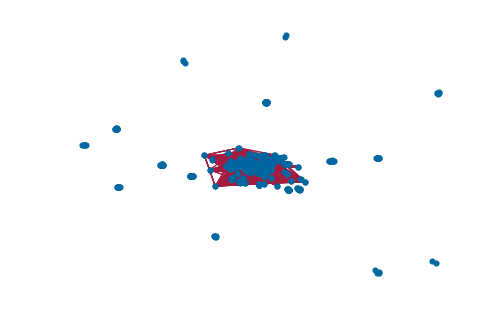

In [9]:
# Transform it in a links data frame (3 columns only):
links = Pearson_ρ.stack().reset_index()
links.columns = ['q1', 'q2','corr']
 
# Remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['q1'] != links['q2']) ]
links_filtered=links_filtered.assign(
    weight=links_filtered["corr"].apply(
        lambda x: 1/abs(x) if x != 0 else np.inf
    )
)

# Drop infinite-length edges
links_filtered = links_filtered.loc[links_filtered["weight"]!=np.inf].copy()

# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'q1', 'q2', 'weight')
 
# Plot the network:
nx.draw(
    G,
    with_labels=False,
    node_size=26,
    node_color='#0067a0',
    edge_color='#a31c3f',
    linewidths=1)

In [10]:
Gp = pg.AGraph()
jdict = jgraph_from_links_filtered(links_filtered)
edge_sizes = [i['edge_size'] for i in jdict['edges']]
edge_size_desc = pd.Series(edge_sizes).describe()

In [30]:
Gp.add_nodes_from(
    list(
        jdict[
            "nodes"
        ]
    ),
    label="",
    shape="point",
    color="#0067a0"
)

for node in Gp.nodes():
    Gp.get_node(
        node
    ).attr[
        "color"
    ] = "#97e2ef" if "DMDD" in node else \
    "#404341" if "MDD" in node else \
    "#eeae30" if "SocAnx" in node else "#0067a0"

# add new edge with custom length (all others have length=2.0):
for edge in jdict["edges"]:
    Gp.add_edge(
        edge[
            "source"
        ],
        edge[
            "target"
        ],
        len=edge[
            "edge_size"
        ],
        color="#000000" if edge[
            "edge_size"
        ] <= edge_size_desc["25%"] else "#f9e28a" if edge[
            "edge_size"
        ] <= edge_size_desc["50%"] else "#e4e4e4" if edge[
            "edge_size"
        ] <= edge_size_desc["75%"] else "#a31c3f",
        width="1.0"
    )
    
Gp.graph_attr.update(size="30!")

# and you can confirm that introspection by drawing & printing this graph:
Gp.draw(
    'all_graphed.png',
    format='png',
    prog='neato'
)

Export for Cytoscape

In [31]:
nx.write_graphml(G, "Pearson_ρ.graphml")

In [12]:
graphs = list(nx.connected_component_subgraphs(G))

In [24]:
num_nodes = {}
for i, g in enumerate(graphs):
    num_nodes[i] = len(
        g.nodes
    )
num_nodes_list = list(
    num_nodes.values()
)
num_nodes_list.sort()
num_nodes

{0: 1876,
 1: 13,
 2: 26,
 3: 49,
 4: 40,
 5: 12,
 6: 15,
 7: 41,
 8: 16,
 9: 2,
 10: 4,
 11: 6,
 12: 2,
 13: 24,
 14: 27,
 15: 61,
 16: 66,
 17: 39,
 18: 41,
 19: 61,
 20: 6,
 21: 6,
 22: 3,
 23: 48,
 24: 12,
 25: 12,
 26: 33,
 27: 21,
 28: 44,
 29: 24}

In [23]:
pd.Series(
    num_nodes_list[:-1]
).describe()

count    29.000000
mean     26.000000
std      19.482593
min       2.000000
25%      12.000000
50%      24.000000
75%      41.000000
max      66.000000
dtype: float64

In [25]:
graphs[9].nodes

NodeView(('FTND_01', 'FTND_02'))

In [65]:
for i, g in enumerate(graphs):
    print("{0}: {1}".format(
        str(i),
        str(g.nodes)
    ))

0: ['ACE_01', 'ACE_02', 'ACE_03', 'ACE_04', 'ACE_05', 'ACE_06', 'ACE_07', 'ACE_08', 'ACE_09', 'ACE_10', 'ARI_P_01', 'ARI_P_02', 'ARI_P_03', 'ARI_P_04', 'ARI_P_05', 'ARI_P_06', 'ARI_P_07', 'ARI_S_01', 'ARI_S_02', 'ARI_S_03', 'ARI_S_04', 'ARI_S_05', 'ARI_S_06', 'ARI_S_07', 'ASR_01', 'ASR_02', 'ASR_03', 'ASR_04', 'ASR_05', 'ASR_06', 'ASR_07', 'ASR_08', 'ASR_09', 'ASR_10', 'ASR_100', 'ASR_101', 'ASR_102', 'ASR_103', 'ASR_104', 'ASR_105', 'ASR_106', 'ASR_107', 'ASR_108', 'ASR_109', 'ASR_11', 'ASR_110', 'ASR_111', 'ASR_112', 'ASR_113', 'ASR_114', 'ASR_115', 'ASR_116', 'ASR_117', 'ASR_118', 'ASR_119', 'ASR_12', 'ASR_121', 'ASR_122', 'ASR_123', 'ASR_124', 'ASR_125', 'ASR_126', 'ASR_13', 'ASR_14', 'ASR_15', 'ASR_16', 'ASR_17', 'ASR_18', 'ASR_19', 'ASR_20', 'ASR_21', 'ASR_22', 'ASR_23', 'ASR_24', 'ASR_25', 'ASR_26', 'ASR_27', 'ASR_28', 'ASR_29', 'ASR_30', 'ASR_31', 'ASR_32', 'ASR_33', 'ASR_34', 'ASR_35', 'ASR_36', 'ASR_37', 'ASR_38', 'ASR_39', 'ASR_40', 'ASR_41', 'ASR_42', 'ASR_43', 'ASR_44', 'A

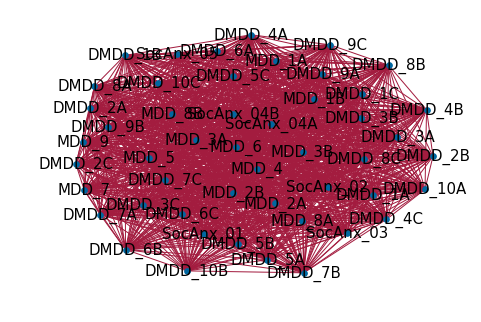

In [66]:
nx.draw(
    graphs[3],
    with_labels=True,
    node_size=32,
    node_color='#0067a0',
    edge_color='#a31c3f',
    linewidths=1,
    font_size=15
)

In [77]:
list(graphs[3].nodes)

['DMDD_10A',
 'DMDD_10B',
 'DMDD_10C',
 'DMDD_1A',
 'DMDD_1B',
 'DMDD_1C',
 'DMDD_2A',
 'DMDD_2B',
 'DMDD_2C',
 'DMDD_3A',
 'DMDD_3B',
 'DMDD_3C',
 'DMDD_4A',
 'DMDD_4B',
 'DMDD_4C',
 'DMDD_5A',
 'DMDD_5B',
 'DMDD_5C',
 'DMDD_6A',
 'DMDD_6B',
 'DMDD_6C',
 'DMDD_7A',
 'DMDD_7B',
 'DMDD_7C',
 'DMDD_8A',
 'DMDD_8B',
 'DMDD_8C',
 'DMDD_9A',
 'DMDD_9B',
 'DMDD_9C',
 'MDD_1A',
 'MDD_1B',
 'MDD_2A',
 'MDD_2B',
 'MDD_3A',
 'MDD_3B',
 'MDD_4',
 'MDD_5',
 'MDD_6',
 'MDD_7',
 'MDD_8A',
 'MDD_8B',
 'MDD_9',
 'SocAnx_01',
 'SocAnx_02',
 'SocAnx_03',
 'SocAnx_04A',
 'SocAnx_04B',
 'SocAnx_05']

In [13]:
Gp3 = pg.AGraph()
jdict3 = jgraph_from_links_filtered(links_filtered.loc[
    links_filtered[
        "q1"
    ].isin(
        pd.Series(
            list(
                graphs[3].nodes
            )
        )
    ) | links_filtered[
        "q2"
    ].isin(
        pd.Series(
            list(
                graphs[3].nodes
            )
        )
    )
])
edge_sizes3 = [i['edge_size'] for i in jdict3['edges']]
edge_size_desc3 = pd.Series(edge_sizes3).describe()

In [37]:
Gp3.add_nodes_from(
    list(
        jdict3[
            "nodes"
        ]
    ),
    label="",
    shape="point",
)

for node in Gp3.nodes():
    Gp3.get_node(
        node
    ).attr[
        "color"
    ] = "#97e2ef" if "DMDD" in node else \
    "#404341" if "MDD" in node else \
    "#eeae30" if "SocAnx" in node else "#0067a0"
    
for edge in jdict3["edges"]:
    Gp3.add_edge(
        edge[
            "source"
        ],
        edge[
            "target"
        ],
        len=edge[
            "edge_size"
        ],
        color="none",
        width="0"
    )

Gp3.graph_attr.update(size="30!")
    
# and you can confirm that introspection by drawing & printing this graph:
Gp3.draw(
    'graph3.png',
    format='png',
    prog='neato'
)

---
Create legend for poster

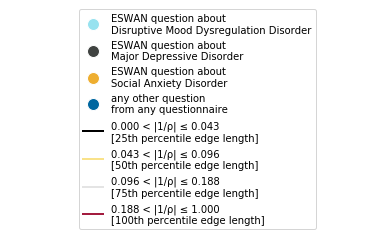

In [77]:
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker='o',
        color='w',
        label='ESWAN question about\nDisruptive Mood Dysregulation Disorder',
        markerfacecolor='#97e2ef',
        markersize=12
    ),
    Line2D(
        [0],
        [0],
        marker='o',
        color='w',
        label='ESWAN question about\nMajor Depressive Disorder',
        markerfacecolor='#404341',
        markersize=12
    ),
    Line2D(
        [0],
        [0],
        marker='o',
        color='w',
        label='ESWAN question about\nSocial Anxiety Disorder',
        markerfacecolor='#eeae30',
        markersize=12
    ),
    Line2D(
        [0],
        [0],
        marker='o',
        color='w',
        label='any other question\nfrom any questionnaire',
        markerfacecolor='#0067a0',
        markersize=12
    ),
    Line2D(
        [0],
        [0],
        color='#000000',
        lw=2,
        label='{0} < |1/ρ| ≤ {1}\n[25th percentile edge length]'.format(
            format(
                edge_size_desc["min"],
                ".3f"
            ),
            format(
                edge_size_desc["25%"],
                ".3f"
            )
        )
    ),
    Line2D(
        [0],
        [0],
        color='#f9e28a',
        lw=2,
        label='{0} < |1/ρ| ≤ {1}\n[50th percentile edge length]'.format(
            format(
                edge_size_desc["25%"],
                ".3f"
            ),
            format(
                edge_size_desc["50%"],
                ".3f"
            )
        )
    ),
    Line2D(
        [0],
        [0],
        color='#e4e4e4',
        lw=2,
        label='{0} < |1/ρ| ≤ {1}\n[75th percentile edge length]'.format(
            format(
                edge_size_desc["50%"],
                ".3f"
            ),
            format(
                edge_size_desc["75%"],
                ".3f"
            )
        )
    ),
    Line2D(
        [0],
        [0],
        color='#a31c3f',
        lw=2,
        label='{0} < |1/ρ| ≤ {1}\n[100th percentile edge length]'.format(
            format(
                edge_size_desc["75%"],
                ".3f"
            ),
            format(
                edge_size_desc["max"],
                ".3f"
            )
        )
    )
]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.savefig('legend.png', dpi=300)
plt.show()